# Benchmarking Our Algorithm against others

In [8]:
import sys
sys.path.append('../')
from panav.environment.env import MultiTunnelEnv
from panav.hybrid import HybridGraph
from panav.util import flowtime,makespan

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
start

array([ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7., -7., -7., -7.,
       -7., -7., -7., -7., -7., -7., -7.])

In [31]:
from panav.SAMP.solvers import Simple_MILP_Planning, Tube_Planning


def sequential_planning(solver,env,vmax,bloating_r):
    continuous_plans = []

    for i in range(len(env.starts)):
        start = env.starts[i,:]
        goal = env.goals[i,:]
        
        
        sol = solver(env,start,goal,vmax = vmax, bloating_r =  bloating_r)
        p = sol.plan(obstacle_trajectories=continuous_plans)    
        if p is None:
            return None
        continuous_plans.append(p)
    
    return continuous_plans

In [35]:
from panav.PBS.PBS import PBS
from panav.TrafficAwarePlanning import TAHP
from time import time
from tqdm import trange
import pickle as pkl

bloating_r = 0.5
vmax = 1.0

n_agents = list(range(1,21))

# Algorithms
algs = {"S2M2": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Simple_MILP_Planning")[0],
        "PBS_Tube": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Tube_Planning")[0],
        "TAHP": lambda hg: TAHP(hg,vmax=vmax,bloating_r=bloating_r),
        "Seq_Tube": lambda hg: sequential_planning(Tube_Planning,hg.env,vmax,bloating_r),
        "Seq_Temp_Obs": lambda hg: sequential_planning(Simple_MILP_Planning,hg.env,vmax,bloating_r)}

timeouted = {alg:False for alg in algs}

max_agents = {
        "S2M2": 7,
        "PBS_Tube": 21,
        "TAHP": 21,
        "Seq_Tube": 21,
        "Seq_Temp_Obs": 21
}

results = []

env_name = "MultiTunnel"


# Execution timeout handling
import signal
# Register an handler for the timeout
def timeout_handler(signum, frame, name,N):
    timeouted[name] = True
    print("Time out for algorithm", name, "N agent = ", N)
    raise TimeoutError
 


# Experiments
for i in range(len(n_agents)):
    N = n_agents[i]
    env = MultiTunnelEnv(n_tunnel = 4, tunnel_width = bloating_r*2.5, N_agent = N)
    HG = HybridGraph(env,bloating_r)

    for name,alg in algs.items():

        if N>max_agents[name] or timeouted[name]:
            continue
        
        print("Alg:", name, "N agent:",N)

        # Register the signal function handler
        signal.signal(signal.SIGALRM, lambda signum,frame:timeout_handler(signum,frame,name,N))
        TIMEOUT = 120 # 1 minute timeout
        signal.alarm(TIMEOUT)

        try:
            result = {}
            
            t0 = time()
            plan = alg(HG)
            t = time()-t0

            result['plan'] = plan
            result['time'] = t
            result['N_agent'] = N
            result['alg_name'] = name

            results.append(result)
        except TimeoutError:
            timeouted[name] = True
            print("Time out for algorithm", name, "N agent = ", N)
        finally:
            # Reset the timeout handler.
            signal.alarm(0)
        
        

    # Save checkpoint data
    with open("./data/{}.pkl".format(env_name),'wb') as fp:
        pkl.dump(results,fp)


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


Alg: S2M2 N agent: 1
Alg: PBS_Tube N agent: 1
Alg: TAHP N agent: 1
Alg: Seq_Tube N agent: 1
Alg: Seq_Temp_Obs N agent: 1
Alg: S2M2 N agent: 2
Alg: PBS_Tube N agent: 2
Alg: TAHP N agent: 2
Alg: Seq_Tube N agent: 2
Alg: Seq_Temp_Obs N agent: 2
Alg: S2M2 N agent: 3
Alg: PBS_Tube N agent: 3
Alg: TAHP N agent: 3
Alg: Seq_Tube N agent: 3
Alg: Seq_Temp_Obs N agent: 3
Alg: S2M2 N agent: 4
Alg: PBS_Tube N agent: 4
Alg: TAHP N agent: 4
Alg: Seq_Tube N agent: 4
Alg: Seq_Temp_Obs N agent: 4
Alg: S2M2 N agent: 5
Alg: PBS_Tube N agent: 5
Alg: TAHP N agent: 5
Alg: Seq_Tube N agent: 5
Alg: Seq_Temp_Obs N agent: 5
Alg: S2M2 N agent: 6
Alg: PBS_Tube N agent: 6
Alg: TAHP N agent: 6
Alg: Seq_Tube N agent: 6
Alg: Seq_Temp_Obs N agent: 6
Alg: S2M2 N agent: 7
Alg: PBS_Tube N agent: 7
Alg: TAHP N agent: 7
Alg: Seq_Tube N agent: 7
Alg: Seq_Temp_Obs N agent: 7
Alg: PBS_Tube N agent: 8
Alg: TAHP N agent: 8
Alg: Seq_Tube N agent: 8
Alg: Seq_Temp_Obs N agent: 8
Alg: PBS_Tube N agent: 9
Alg: TAHP N agent: 9
Alg: Se

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/cvxpy/problems/problem.py:1391: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)



Interrupt request received


SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [37]:
# Visualize the simulation results
metrics = {"Makespan": lambda result: makespan(result['plan']),
           "Flowtime": lambda result: flowtime(result['plan']),
           "Throuput per 60s": lambda result: result['N_agent']/makespan(result['plan']) * 60,
           "Ave. Travel Cost": lambda result: flowtime(result['plan'])/result['N_agent'],
           "Compute Time": lambda result: result['time']}

performance = {}

for result in results:
    if  result['plan'] is not None and result['plan'][-1] is not None:
        # print(result['plan'][-1])
        alg = result['alg_name']
        if alg not in performance:
            performance[alg] = {}
            performance[alg]['n_agents'] = []
        
        performance[alg]['n_agents'].append(result['N_agent'])

        for metric, eval in metrics.items():
            if metric not in performance[alg]:
                performance[alg][metric] = []
            
            performance[alg][metric].append(eval(result))

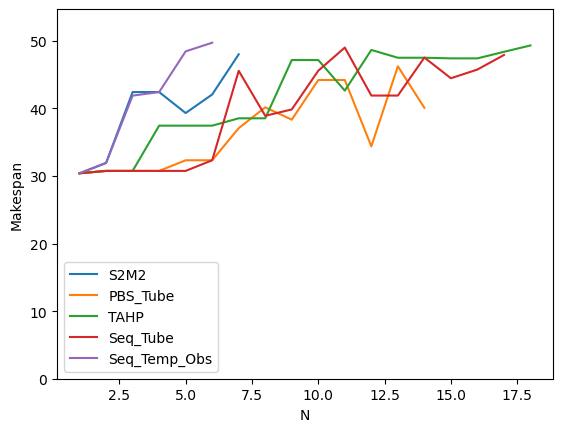

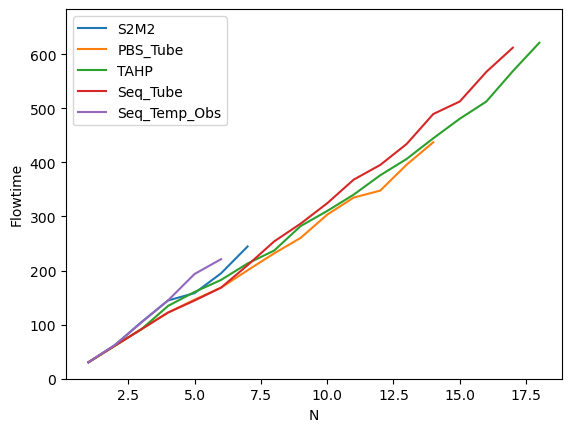

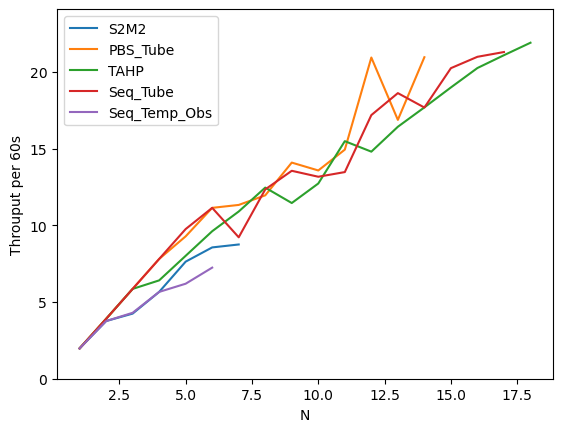

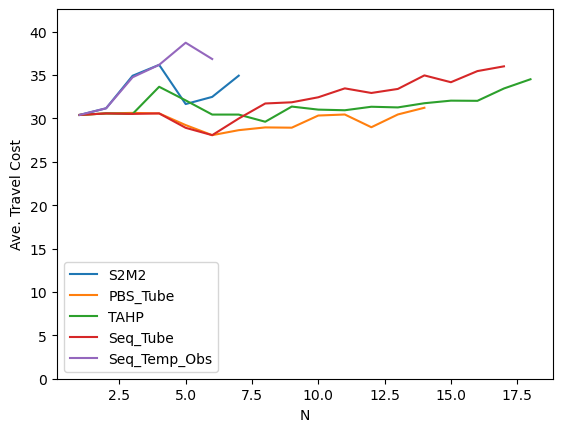

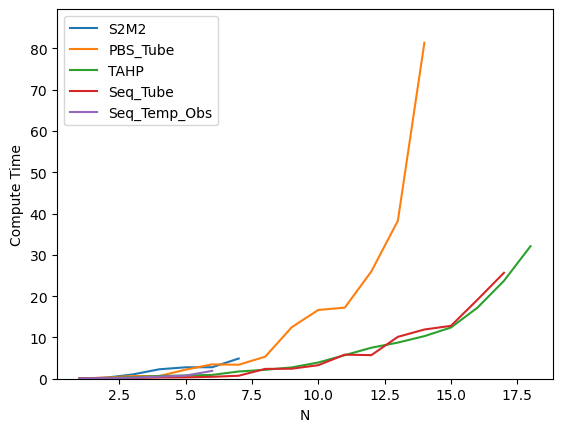

In [38]:
from matplotlib import pyplot as plt

for metric in metrics:
    plt.figure()
    plt.ylabel(metric)
    plt.xlabel("N")
    # plt.ylim((0,20))
    ymax = 0
    for alg in performance:
        plt.plot(performance[alg]['n_agents'],performance[alg][metric],label = alg)
        ymax = max(ymax,max(performance[alg][metric]))
    plt.ylim(0.0,ymax*1.1)
    plt.legend()
    plt.show()

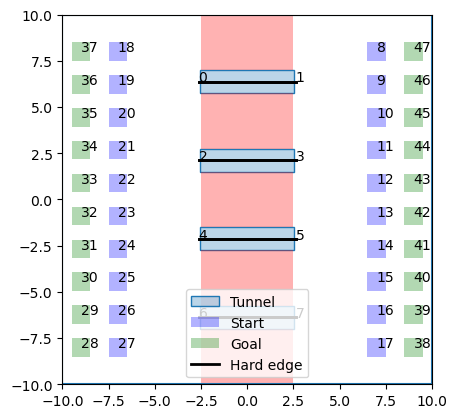

In [20]:
from panav.viz import draw_hybrid
draw_hybrid(HG)